# Construct Table and Reread

Collaborator: Helen Yu, Lixin Xu

In [36]:
# Preprocessing and Feature Engineering
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SQLContext
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.sql.functions import *
from pyspark.sql.types import *


# Training
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import nn, optim
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator


# Others
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

In [9]:
appName = "Ingest Player Data"  
master = "local"             

conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

sc = SparkContext.getOrCreate(conf=conf)
sqlContext = SQLContext(sc)
spark = sqlContext.sparkSession.builder.getOrCreate()

In [10]:
female_files = ['female_players_16.csv', 'female_players_17.csv', 
                'female_players_18.csv', 'female_players_19.csv', 
                'female_players_20.csv', 'female_players_21.csv', 
                'female_players_22.csv']

male_files = ['players_15.csv', 'players_16.csv', 'players_17.csv', 
              'players_18.csv', 'players_19.csv', 'players_20.csv', 
              'players_21.csv', 'players_22.csv']

female_df = None
male_df = None

# Load all female files
for file in female_files:
    year = '20' + file[-6:-4]
    df = spark.read.csv(f'data/{file}', header=True, inferSchema=True)
    df = df.withColumn('year', lit(year))
    df = df.withColumn('gender', lit('Female'))
    if female_df is None:
        female_df = df
    else:
        female_df = female_df.union(df)

# Load all male files
for file in male_files:
    year = '20' + file[-6:-4]
    df = spark.read.csv(f'data/{file}', header=True, inferSchema=True)
    df = df.withColumn('year', lit(year))
    df = df.withColumn('gender', lit('Male'))
    if male_df is None:
        male_df = df
    else:
        male_df = male_df.union(df)

# Combine both male and female data
combined_df = female_df.union(male_df)

combined_df.printSchema()
print(len(combined_df.columns))
print(combined_df.count())

root
 |-- sofifa_id: integer (nullable = true)
 |-- player_url: string (nullable = true)
 |-- short_name: string (nullable = true)
 |-- long_name: string (nullable = true)
 |-- player_positions: string (nullable = true)
 |-- overall: integer (nullable = true)
 |-- potential: integer (nullable = true)
 |-- value_eur: string (nullable = true)
 |-- wage_eur: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- dob: date (nullable = true)
 |-- height_cm: integer (nullable = true)
 |-- weight_kg: integer (nullable = true)
 |-- club_team_id: string (nullable = true)
 |-- club_name: string (nullable = true)
 |-- league_name: string (nullable = true)
 |-- league_level: string (nullable = true)
 |-- club_position: string (nullable = true)
 |-- club_jersey_number: string (nullable = true)
 |-- club_loaned_from: string (nullable = true)
 |-- club_joined: string (nullable = true)
 |-- club_contract_valid_until: string (nullable = true)
 |-- nationality_id: integer (nullable = true)
 |

144323


### !!! CHANGE DATABASE CONFIGS TO YOURS !!!!

In [11]:
db_properties = {
    "username": "postgres",   
    "password": "password",   
    'url': "jdbc:postgresql://localhost:5433/14787db",  
    'table': "fifa",
    'driver': "org.postgresql.Driver"
}

combined_df.write.format("jdbc")\
    .mode("overwrite")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("driver", db_properties['driver'])\
    .save()

In [12]:
db_properties = {
    "username": "postgres",   
    "password": "password",   
    'url': "jdbc:postgresql://localhost:5433/14787db",  
    'table': "fifa",
    'driver': "org.postgresql.Driver"
}

df = sqlContext.read.format("jdbc")\
    .option("url", db_properties['url'])\
    .option("dbtable", db_properties['table'])\
    .option("user", db_properties['username'])\
    .option("password", db_properties['password'])\
    .option("Driver", db_properties['driver'])\
    .load()

df = df.filter(df['gender'] == 'Male')
print(df.count())

142079


# Spark Analysis

## Function 1
In Year X, what were the Y clubs that had the highest number of players with contracts ending in year Z (or after)?
1.  X is a year between (2015 and 2022, inclusively).
2.  Y is a positive integer.
3.  Z is a year that can hold the value of 2023 or a year after it.

In [13]:
# Columns:  year, club_name, club_contract_valid_until

def top_clubs_by_contract_end_year(df, X:str, Y:int, Z:str):
    if type(X) != str:
        raise TypeError("X must be an string")
    elif not (2015 <= int(X) <= 2022):
        raise ValueError("X must be a year between 2015 and 2022 inclusively.")
    
    if type(Y) != int:
        raise TypeError("Y must be a positive integer")
    elif int(Y) <= 0:
        raise ValueError(("Y must be a positive integer"))
    
    if type(Z) != str:
        raise TypeError("X must be an string")
    elif int(Z) < 2023:
        raise ValueError("Z must be a year that is 2023 or later.")
    
    mask_1 = df["year"] == X
    mask_2 = df["club_contract_valid_until"] >= Z
    df = df.filter(mask_1 & mask_2)
    
    club_count_df = df.groupBy("club_name") \
        .agg(count("club_name").alias("Player_Count")) \
        .orderBy(desc("Player_Count")) \
        .limit(Y)
    
    club_count_df.show()


X = '2017'
Y = 5
Z = '2023'

top_clubs_by_contract_end_year(df, X, Y, Z)

+--------------------+------------+
|           club_name|Player_Count|
+--------------------+------------+
|         Envigado FC|          14|
|   Alianza Petrolera|          12|
|Club Atlético Tem...|          12|
|Club de Deportes ...|          12|
| Seattle Sounders FC|          12|
+--------------------+------------+



## Function 2
In sports, maturity and energy of teams depend on the average age of team
players (among other factors). Therefore, it’s important to have a function that
can find clubs with such features.

List the X clubs with the highest (or lowest) average player age for a given
year Y.
- X represents a positive integer, but you should handle a scenario if
X is not positive value.
- Y represents a year between 2015 and 2022 inclusively.
- Provide the user with the ability to choose if they want the highest
average age or the lowest average age.
- Make sure to handle this scenario as well: if the user requests 5
clubs with highest averages but there are 3 clubs that share the
same count at rank number 5, please include all of them in your
output

In [ ]:
def club_by_avg_age (df, X, Y, orderby):
    
    if type(X) != int:
        raise TypeError("X must be an integer")
    elif X <= 0:
        raise ValueError("X should be a positive integer.")
    
    if type(Y) != str:
        raise TypeError("Y must be an string")
    elif not (2015 <= int(Y) <= 2022):
        raise ValueError("Y should be between 2015 and 2022 inclusively.")
    
    if orderby != 'highest' and orderby != 'lowest':
        raise ValueError("orderby must either be 'highest' or 'lowest'.")

    mask_1 = df["year"] == Y
    df = df.filter(mask_1)  

    avg_age_df = df.groupBy("club_name") \
        .agg(avg("age").alias("Average_Age")) \
        .orderBy(desc("Average_Age"))

    sort_order = desc("Average_Age") if orderby == 'highest' else asc("Average_Age")
    threshold_avg_age = avg_age_df.select("Average_Age") \
        .distinct() \
        .orderBy(sort_order) \
        .limit(5) \
        .collect()[-1]["Average_Age"]

    if orderby == 'highest':
        result_df = avg_age_df.filter(col("Average_Age") >= threshold_avg_age)
    else:
        result_df = avg_age_df.filter(col("Average_Age") <= threshold_avg_age)

    result_df.show()


X = 5
Y = '2020'
orderby = 'highest'
club_by_avg_age(df, X, Y, orderby)

+--------------------+-----------+
|           club_name|Average_Age|
+--------------------+-----------+
|           Fortaleza|       32.6|
|            Cruzeiro|       31.6|
|Club Athletico Pa...|       31.4|
|            Botafogo|       31.4|
|Associação Chapec...|       31.4|
|             Avaí FC|       31.2|
|          Fluminense|       31.2|
| Ceará Sporting Club|       31.2|
|               Goiás|       31.0|
|               Bahia|       31.0|
|              Grêmio|       31.0|
+--------------------+-----------+



## Function 3
What is the most popular nationality in the dataset for each year? (i.e. display the most frequent nation for 2015, 2016, etc.)

In [15]:
from pyspark.sql.window import Window

def most_popular_nationality(df):   
    count_df = df.groupBy("year", "nationality_name") \
        .count() \
        .withColumnRenamed("count", "nationality_count")

    window = Window.partitionBy("year").orderBy(desc("nationality_count"))

    result_df = count_df \
        .withColumn("rank", row_number().over(window)) \
        .filter(col("rank") == 1) \
        .select("year", "nationality_name", col("nationality_count").alias("max_count"))
    
    result_df.show()

most_popular_nationality(df)

+----+----------------+---------+
|year|nationality_name|max_count|
+----+----------------+---------+
|2015|         England|     1627|
|2016|         England|     1519|
|2017|         England|     1627|
|2018|         England|     1633|
|2019|         England|     1625|
|2020|         England|     1670|
|2021|         England|     1685|
|2022|         England|     1719|
+----+----------------+---------+



# Feature Engineeirng

In [16]:
# Columns to include
# We don't have binary cols or non-ordered categorical cols
continuous_cols = ['overall', 'potential', 'wage_eur', 'age', 'height_cm', 'weight_kg', 'league_level', 'weak_foot', 'skill_moves', 'international_reputation',
                   'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_volleys', 
                   'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 
                   'movement_reactions', 'movement_balance', 'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots', 'mentality_aggression', 
                   'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'defending_marking_awareness', 'defending_standing_tackle', 
                   'defending_sliding_tackle', 'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning', 'goalkeeping_reflexes']

nominal_cols = ['work_rate']

binary_cols = []

output_cols = ['value_eur']

In [17]:
df = df.select(continuous_cols + nominal_cols + binary_cols + output_cols)

# deduplicate
df = df.distinct()

## Missing Values

### Count Nulls

In [18]:
class MissingValueHandler(Transformer): 
    def __init__(self, drop=False, impute_num=False, impute_cat=False):
        super().__init__()
        self.drop = drop
        self.impute_num = impute_num
        self.impute_cat = impute_cat

    def _transform(self, df):
        # Substitute emtpy values to 'NA'
        missing_value = "NA"
        for item in df.columns:
            df = df.withColumn(
                f"{item}",
                when(df[item] == missing_value, lit(None)).otherwise(df[item])
            )

        # Report null values
        print('------Total Missing Values-----------------------')
        df.persist()
        null_counts_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                                    for c in df.columns])
        null_counts_df.show(1, truncate=False, vertical=True)
        df.unpersist()

        # Drop
        if self.drop is True:
            df = df.filter(~df['pace'].isNull() & ~df['shooting'].isNull())
            print(f'number of samples after dropping nulls: {df.count()}')
        
        # Impute Numerical
        if self.impute_num is True:
            num_impute_list = ['wage_eur', 'league_level', 'value_eur']
            impossible_value = float('inf')

            df = df.fillna(impossible_value, num_impute_list)

            for item in num_impute_list:
                imputer = Imputer(
                        inputCols=num_impute_list,
                        outputCols=["{}_imputed".format(c) for c in num_impute_list])\
                        .setStrategy("median").setMissingValue(impossible_value)
                df = imputer.fit(df).transform(df)
            
            df = df.drop(*num_impute_list)

        # Double-check null values
        print('------Current Missing Value-----------------------')
        df.persist()
        null_counts_df = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) \
                                    for c in df.columns])
        null_counts_df.show(1, truncate=False, vertical=True)
        df.unpersist()

        return df

## Drop Outliers


In [19]:
def column_add(a,b):
     return  a.__add__(b)
    
def find_outliers(df):
    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    # df = df.withColumn('total_outliers', reduce(column_add, (df[col] for col in selected_columns)))

     # Check if there are any outlier columns; if not, set total_outliers to 0
    if selected_columns:
        # Calculate total outliers by summing the outlier columns
        df = df.withColumn('total_outliers', reduce(column_add, (df[col] for col in selected_columns)))
    else:
        # No outliers; set total_outliers to 0
        df = df.withColumn('total_outliers', F.lit(0))


    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df


class OutlierHandler(Transformer):
    def __init__(self, num_outlier_thres, drop=False):
        super().__init__()
        self.drop = drop
        self.num_outlier_thres = num_outlier_thres

    def _transform(self, df):
        df_outlier = find_outliers(df)
        print('------Total Outliers-----------------------')
        df_outlier.groupby("total_outliers").count().show()

        if self.drop is True:
            df = df_outlier.filter(df_outlier['total_Outliers'] <= self.num_outlier_thres)
            print(f'number of samples after dropping outliers: {df.count()}')
            df = df.drop('total_outliers')

        return df

## Correlation

In [20]:
class CorrelationHandler(Transformer):
    def __init__(self, drop, continuous_corr_cols):
        super().__init__()
        self.drop = drop
        self.continuous_corr_cols = continuous_corr_cols

    def _transform(self, df):
        correlation_matrix = df[self.continuous_corr_cols].toPandas().corr()
        print(correlation_matrix)

        # drop correlated columns
        if self.drop is True:
            correlated_cols = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
                         'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle']
            df = df.drop(*correlated_cols)
        
        return df

## Log Transform

In [21]:
class LogTransformer(Transformer):
    def __init__(self):
        super().__init__()

    def _transform(self, df):
        log_wage = F.log1p('wage_eur_imputed').alias('log_wage')
        df = df.withColumn('log_wage', log_wage).drop('wage_eur_imputed')
        log_value = F.log1p('value_eur_imputed').alias('log_value')
        df = df.withColumn('log_value', log_value).drop('value_eur_imputed')

        return df      

## Pipeline

In [22]:
class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset.withColumn('outcome', col('log_value').cast(DoubleType())).drop("log_value")
        return output_df
    
class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols + output_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))
        return output_df
    
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

In [23]:
def get_pipeline(proceed=False):
    # Initialize stages
    stage_typecaster = FeatureTypeCaster()
    
    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols)

    if proceed is False:
        # SET TO FALSE WHEN TO SEE DATA, SET TO TRUE TO EDIT DATA
        missing_value_handler = MissingValueHandler(drop=False, impute_num=False, impute_cat=False)
        outlier_handler = OutlierHandler(num_outlier_thres=3, drop=False)
        correlation_handler = CorrelationHandler(drop=False, continuous_corr_cols=continuous_cols)
        
        pipeline = Pipeline(stages=[stage_typecaster, stage_nominal_indexer, missing_value_handler, outlier_handler, correlation_handler])


    if proceed is True:
        # SET TO FALSE WHEN TO SEE DATA, SET TO TRUE TO EDIT DATA
        missing_value_handler = MissingValueHandler(drop=True, impute_num=True, impute_cat=True) 
        outlier_handler = OutlierHandler(num_outlier_thres=3, drop=True)

        to_remove_conti_cols = ['wage_eur', 'league_level']  # remove columns become useless in MissingValue and Outlier
        to_add_conti_cols = ['wage_eur_imputed', 'league_level_imputed']  # add columns created by in MissingValue and Outlier
        print(len(continuous_cols))
        continuous_corr_cols = continuous_cols + to_add_conti_cols     
        for col_name in to_remove_conti_cols:
            continuous_corr_cols.remove(col_name)
        print(len(continuous_corr_cols))
        
        correlation_handler = CorrelationHandler(drop=True, continuous_corr_cols=continuous_corr_cols)  # 要加上nominal_id_cols?????????
        log_transformer = LogTransformer()
        
        to_remove_feat_cols = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
                               'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle', 'wage_eur_imputed']  # remove columns become useless in Correlation and LogTransformer
        to_add_feat_cols = ['log_wage']  # add columns created in Correlation and LogTransformer
        feature_cols = continuous_corr_cols + nominal_id_cols + binary_cols + to_add_feat_cols
        print(len(feature_cols))
        for col_name in to_remove_feat_cols:
            feature_cols.remove(col_name)
        print(len(feature_cols))
        
        # Vector assembler and scaler
        stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

        stage_scaler = StandardScaler(inputCol='vectorized_features', outputCol='features')
        
        # Outcome column and column dropper
        stage_outcome = OutcomeCreater()
        stage_column_dropper = ColumnDropper(columns_to_drop=feature_cols + nominal_cols + output_cols + ['vectorized_features'])

        # Connect the columns into a pipeline
        pipeline = Pipeline(stages=[stage_typecaster, stage_nominal_indexer, missing_value_handler, outlier_handler, correlation_handler, 
                                    log_transformer, stage_vector_assembler, stage_scaler, stage_outcome, stage_column_dropper])
        print('EXIT')

    return pipeline

### !!! RUN THESE FIRST !!!

In [24]:
pipeline = get_pipeline(proceed=False)
model = pipeline.fit(df)

processed_df = model.transform(df)

------Total Missing Values-----------------------


-RECORD 0----------------------------
 overall                     | 0     
 potential                   | 0     
 wage_eur                    | 1622  
 age                         | 0     
 height_cm                   | 0     
 weight_kg                   | 0     
 league_level                | 2015  
 weak_foot                   | 0     
 skill_moves                 | 0     
 international_reputation    | 0     
 pace                        | 15791 
 shooting                    | 15791 
 passing                     | 15791 
 dribbling                   | 15791 
 defending                   | 15791 
 physic                      | 15791 
 attacking_crossing          | 0     
 attacking_finishing         | 0     
 attacking_heading_accuracy  | 0     
 attacking_volleys           | 0     
 skill_dribbling             | 0     
 skill_curve                 | 0     
 skill_fk_accuracy           | 0     
 skill_long_passing          | 0     
 skill_ball_control          | 0     
 movement_ac

-RECORD 0----------------------------
 overall                     | 0     
 potential                   | 0     
 wage_eur                    | 1622  
 age                         | 0     
 height_cm                   | 0     
 weight_kg                   | 0     
 league_level                | 2015  
 weak_foot                   | 0     
 skill_moves                 | 0     
 international_reputation    | 0     
 pace                        | 15791 
 shooting                    | 15791 
 passing                     | 15791 
 dribbling                   | 15791 
 defending                   | 15791 
 physic                      | 15791 
 attacking_crossing          | 0     
 attacking_finishing         | 0     
 attacking_heading_accuracy  | 0     
 attacking_volleys           | 0     
 skill_dribbling             | 0     
 skill_curve                 | 0     
 skill_fk_accuracy           | 0     
 skill_long_passing          | 0     
 skill_ball_control          | 0     
 movement_ac

+--------------+------+
|total_outliers| count|
+--------------+------+
|             0|142076|
+--------------+------+



                              overall  potential  wage_eur       age  \
overall                      1.000000   0.699596  0.613277  0.457357   
potential                    0.699596   1.000000  0.513862 -0.196961   
wage_eur                     0.613277   0.513862  1.000000  0.169208   
age                          0.457357  -0.196961  0.169208  1.000000   
height_cm                    0.045350   0.005069  0.024590  0.083013   
weight_kg                    0.140648  -0.009009  0.066679  0.227176   
league_level                -0.225711  -0.193698 -0.155691 -0.060770   
weak_foot                    0.219841   0.170237  0.150499  0.076614   
skill_moves                  0.327678   0.287080  0.234463  0.024063   
international_reputation     0.490408   0.372928  0.686565  0.255837   
pace                         0.188316   0.265500  0.147445 -0.199926   
shooting                     0.482646   0.321011  0.323270  0.231949   
passing                      0.677269   0.456370  0.424751  0.33

### !!! THEN RUN THESE !!!

In [25]:
pipeline = get_pipeline(proceed=True)
model = pipeline.fit(df)

processed_df = model.transform(df)

48
48
50
42
EXIT


------Total Missing Values-----------------------


-RECORD 0----------------------------
 overall                     | 0     
 potential                   | 0     
 wage_eur                    | 1622  
 age                         | 0     
 height_cm                   | 0     
 weight_kg                   | 0     
 league_level                | 2015  
 weak_foot                   | 0     
 skill_moves                 | 0     
 international_reputation    | 0     
 pace                        | 15791 
 shooting                    | 15791 
 passing                     | 15791 
 dribbling                   | 15791 
 defending                   | 15791 
 physic                      | 15791 
 attacking_crossing          | 0     
 attacking_finishing         | 0     
 attacking_heading_accuracy  | 0     
 attacking_volleys           | 0     
 skill_dribbling             | 0     
 skill_curve                 | 0     
 skill_fk_accuracy           | 0     
 skill_long_passing          | 0     
 skill_ball_control          | 0     
 movement_ac

number of samples after dropping nulls: 126285


------Current Missing Value-----------------------


-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy           | 0   
 skill_long_passing          | 0   
 skill_ball_control          | 0   
 movement_acceleration       | 0   
 movement_sprint_speed       | 0   
 movement_agility            | 0   
 movement_reactions         

+--------------+------+
|total_outliers| count|
+--------------+------+
|             0|126285|
+--------------+------+



number of samples after dropping outliers: 126285


                              overall  potential       age  height_cm  \
overall                      1.000000   0.692786  0.458388   0.068753   
potential                    0.692786   1.000000 -0.207768   0.026039   
age                          0.458388  -0.207768  1.000000   0.066605   
height_cm                    0.068753   0.026039  0.066605   1.000000   
weight_kg                    0.163461   0.010334  0.211202   0.747727   
weak_foot                    0.219153   0.156409  0.108090  -0.098688   
skill_moves                  0.391331   0.323398  0.100063  -0.274995   
international_reputation     0.491617   0.368863  0.259659   0.047116   
pace                         0.188316   0.265500 -0.199926  -0.411740   
shooting                     0.482646   0.321011  0.231949  -0.189806   
passing                      0.677269   0.456370  0.330927  -0.272325   
dribbling                    0.600396   0.487091  0.159494  -0.394848   
defending                    0.322140   0.158281  0

------Total Missing Values-----------------------


-RECORD 0----------------------------
 overall                     | 0     
 potential                   | 0     
 wage_eur                    | 1622  
 age                         | 0     
 height_cm                   | 0     
 weight_kg                   | 0     
 league_level                | 2015  
 weak_foot                   | 0     
 skill_moves                 | 0     
 international_reputation    | 0     
 pace                        | 15791 
 shooting                    | 15791 
 passing                     | 15791 
 dribbling                   | 15791 
 defending                   | 15791 
 physic                      | 15791 
 attacking_crossing          | 0     
 attacking_finishing         | 0     
 attacking_heading_accuracy  | 0     
 attacking_volleys           | 0     
 skill_dribbling             | 0     
 skill_curve                 | 0     
 skill_fk_accuracy           | 0     
 skill_long_passing          | 0     
 skill_ball_control          | 0     
 movement_ac

number of samples after dropping nulls: 126285


------Current Missing Value-----------------------


-RECORD 0--------------------------
 overall                     | 0   
 potential                   | 0   
 age                         | 0   
 height_cm                   | 0   
 weight_kg                   | 0   
 weak_foot                   | 0   
 skill_moves                 | 0   
 international_reputation    | 0   
 pace                        | 0   
 shooting                    | 0   
 passing                     | 0   
 dribbling                   | 0   
 defending                   | 0   
 physic                      | 0   
 attacking_crossing          | 0   
 attacking_finishing         | 0   
 attacking_heading_accuracy  | 0   
 attacking_volleys           | 0   
 skill_dribbling             | 0   
 skill_curve                 | 0   
 skill_fk_accuracy           | 0   
 skill_long_passing          | 0   
 skill_ball_control          | 0   
 movement_acceleration       | 0   
 movement_sprint_speed       | 0   
 movement_agility            | 0   
 movement_reactions         

+--------------+------+
|total_outliers| count|
+--------------+------+
|             0|126285|
+--------------+------+



number of samples after dropping outliers: 126285


                              overall  potential       age  height_cm  \
overall                      1.000000   0.692786  0.458388   0.068753   
potential                    0.692786   1.000000 -0.207768   0.026039   
age                          0.458388  -0.207768  1.000000   0.066605   
height_cm                    0.068753   0.026039  0.066605   1.000000   
weight_kg                    0.163461   0.010334  0.211202   0.747727   
weak_foot                    0.219153   0.156409  0.108090  -0.098688   
skill_moves                  0.391331   0.323398  0.100063  -0.274995   
international_reputation     0.491617   0.368863  0.259659   0.047116   
pace                         0.188316   0.265500 -0.199926  -0.411740   
shooting                     0.482646   0.321011  0.231949  -0.189806   
passing                      0.677269   0.456370  0.330927  -0.272325   
dribbling                    0.600396   0.487091  0.159494  -0.394848   
defending                    0.322140   0.158281  0

In [26]:
processed_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)



### analysis on correlated column

mentality_vision and passing, 0.87 --> keep both, because 0.87 is not extreme and they measure distinct aspects (technical vs. mental) of players

defending_marking_awareness and defending, 0.96 \
defending_marking_awareness and mentality_interceptions, 0.91 \
defending_marking_awareness and defending_standing_tackle, 0.93 \
defending_marking_awareness and defending_sliding_tackle, 0.93 

defending_standing_tackle and defending, 0.97 \
defending_standing_tackle and mentality_interceptions, 0.93 \
defending_standing_tackle and defending_marking_awareness, 0.93 \
defending_standing_tackle and defending_sliding_tackle, 0.97 \

........

-> drop three `defending_...` and kept `defending`, as it's a summary of the other three.

goalkeeping_diving:
goalkeeping_handling                        -0.497156            0.969151   
goalkeeping_kicking                         -0.496211            0.964969   
goalkeeping_positioning                     -0.493827            0.968941   
goalkeeping_reflexes                        -0.497315            0.972929 

goalkeeping_reflexes:
goalkeeping_diving                          0.968941              0.972929  
goalkeeping_handling                        0.968601              0.969271  
goalkeeping_kicking                         0.963895              0.965574  
goalkeeping_positioning                     1.000000              0.969205  

........

-> keep `goalkeeping_reflexes` as it has the highest correlation with the other `goalkeeping_...` features, signifying it's the best summary of them. Also, in reality to assess player's goalkeeping ability
`goalkeeping_reflexes` is the most important metric among what we have here.

# Machine Learning

In [27]:
training_data, test_data = processed_df.randomSplit([0.8, 0.2], seed=42)

## PySpark

In [ ]:
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

rf_regressor = RandomForestRegressor(
    featuresCol="features",
    labelCol="outcome"
)

lr_regressor = LinearRegression(
    featuresCol="features",
    labelCol="outcome"
)

evaluator_rmse = RegressionEvaluator(
    labelCol="outcome",
    predictionCol="prediction",
    metricName="rmse"
)

rf_param_grid = ParamGridBuilder() \
    .addGrid(rf_regressor.numTrees, [5, 10]) \
    .addGrid(rf_regressor.maxDepth, [5, 8]) \
    .build()

lr_param_grid = ParamGridBuilder() \
    .addGrid(lr_regressor.regParam, [0.01, 0.1]) \
    .addGrid(lr_regressor.maxIter, [5, 10]) \
    .build()

rf_crossval = CrossValidator(
    estimator=rf_regressor,
    estimatorParamMaps=rf_param_grid,
    evaluator=evaluator_rmse,
)

lr_crossval = CrossValidator(
    estimator=lr_regressor,
    estimatorParamMaps=lr_param_grid,
    evaluator=evaluator_rmse,
)

In [ ]:
rf_model = rf_crossval.fit(training_data)
lr_model = lr_crossval.fit(training_data)

rf_predictions = rf_model.transform(test_data)
lr_predictions = lr_model.transform(test_data)

# Evaluate the models using RMSE
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
lr_rmse = evaluator_rmse.evaluate(lr_predictions)

Random Forest RMSE (Cross-Validated): 0.3392700574815871
Linear Regression RMSE (Cross-Validated): 0.3717207146817184


In [53]:
evaluator_r2 = RegressionEvaluator(
    labelCol="outcome",
    predictionCol="prediction",
    metricName="r2"
)

rf_r2 = evaluator_r2.evaluate(rf_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

In [54]:
# Best models
print("\nBest Parameters for Random Forest Model:")
print("  - numTrees:", rf_model.bestModel.getNumTrees)
print("  - maxDepth:", rf_model.bestModel.getMaxDepth())

print(f"Random Forest RMSE (Cross-Validated): {rf_rmse}")
print(f"Random Forest R-squared (Cross-Validated): {rf_r2}")


print("\nBest Parameters for Linear Regression Model:")
print("  - regParam:", lr_model.bestModel._java_obj.getRegParam())
print("  - maxIter:", lr_model.bestModel._java_obj.getMaxIter())

print(f"Linear Regression RMSE (Cross-Validated): {lr_rmse}")
print(f"Linear Regression R-squared (Cross-Validated): {lr_r2}")


Best Parameters for Random Forest Model:
  - numTrees: 10
  - maxDepth: 8
Random Forest RMSE (Cross-Validated): 0.3392700574815871
Random Forest R-squared (Cross-Validated): 0.9359894961931062

Best Parameters for Linear Regression Model:
  - regParam: 0.01
  - maxIter: 5
Linear Regression RMSE (Cross-Validated): 0.3717207146817184
Linear Regression R-squared (Cross-Validated): 0.9231588762327542


## PyTorch

In [46]:
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch

# Convert Spark DataFrames to Pandas
train_df = training_data.toPandas()
test_df = test_data.toPandas()

# Training
X_train = torch.from_numpy(np.array(train_df['features'].values.tolist(), np.float32))
y_train = torch.from_numpy(np.array(train_df['outcome'].values.tolist(), np.float32)).reshape(-1, 1)

# Validation and Testing
X_test = torch.from_numpy(np.array(test_df['features'].values.tolist(), np.float32))
y_test = torch.from_numpy(np.array(test_df['outcome'].values.tolist(), np.float32)).reshape(-1, 1)

# Dataloader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

### Use GPU

In [37]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Shallow NN

In [ ]:
class ShallowNN(nn.Module):
    def __init__(self, input_size):
        super(ShallowNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 1)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

input_size = X_train.shape[1]  # Number of features
shallow_model = ShallowNN(input_size).to(device)

## Deep NN

In [ ]:
class DeepNN(nn.Module):
    def __init__(self, input_size):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)

deep_model = DeepNN(input_size).to(device)

In [ ]:
def train_model(model, train_loader, test_loader, learning_rate, num_epochs):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)

    # Return the final loss, loss history, and trained model
    return avg_loss, train_losses, model

In [48]:
# Hyperparameters to tune
learning_rates = [0.001, 0.0005]
epochs = [20, 40]

# Track the best configuration and loss
best_shallow_loss = float('inf')
best_deep_loss = float('inf')
shallow_loss_curves = {}
deep_loss_curves = {}

# Initialize variables to hold the best models
best_shallow_model = None
best_deep_model = None

# Shallow model tuning
for lr in learning_rates:
    for epoch in epochs:
        print(f"Training Shallow Model with lr={lr}, epochs={epoch}")
        shallow_loss, shallow_loss_history, trained_shallow_model = train_model(shallow_model, train_loader, test_loader, lr, epoch)
        shallow_loss_curves[f"lr={lr}_epochs={epoch}"] = shallow_loss_history
        if shallow_loss < best_shallow_loss:
            best_shallow_loss = shallow_loss
            best_shallow_params = {'learning_rate': lr, 'epochs': epoch}
            best_shallow_model = trained_shallow_model  # Save the best shallow model

# Deep model tuning
for lr in learning_rates:
    for epoch in epochs:
        print(f"Training Deep Model with lr={lr}, epochs={epoch}")
        deep_loss, deep_loss_history, trained_deep_model = train_model(deep_model, train_loader, test_loader, lr, epoch)
        deep_loss_curves[f"lr={lr}_epochs={epoch}"] = deep_loss_history
        if deep_loss < best_deep_loss:
            best_deep_loss = deep_loss
            best_deep_params = {'learning_rate': lr, 'epochs': epoch}
            best_deep_model = trained_deep_model  # Save the best deep model

print(f"Best Shallow Model Loss: {best_shallow_loss} with params {best_shallow_params}")
print(f"Best Deep Model Loss: {best_deep_loss} with params {best_deep_params}")

# Save the best models to disk
torch.save(best_shallow_model.state_dict(), "best_shallow_model.pth")
torch.save(best_deep_model.state_dict(), "best_deep_model.pth")

Training Shallow Model with lr=0.001, epochs=20
Training Shallow Model with lr=0.001, epochs=40
Training Shallow Model with lr=0.0005, epochs=20
Training Shallow Model with lr=0.0005, epochs=40
Training Deep Model with lr=0.001, epochs=20
Training Deep Model with lr=0.001, epochs=40
Training Deep Model with lr=0.0005, epochs=20
Training Deep Model with lr=0.0005, epochs=40
Best Shallow Model Loss: 0.13518594480701354 with params {'learning_rate': 0.0005, 'epochs': 40}
Best Deep Model Loss: 0.09931938456915929 with params {'learning_rate': 0.0005, 'epochs': 40}


In [51]:
def calculate_r2(y_true, y_pred):
    # Convert tensors to numpy arrays
    y_true = y_true.detach().cpu().numpy()
    y_pred = y_pred.detach().cpu().numpy()
    
    # Calculate R-squared
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)

    return r2


# Load the best shallow model
loaded_shallow_model = ShallowNN(input_size).to(device)
loaded_shallow_model.load_state_dict(torch.load("best_shallow_model.pth"))
loaded_shallow_model.eval()

# Calculate R-squared for the shallow model
shallow_preds = []
shallow_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = loaded_shallow_model(X_batch)
        shallow_preds.append(outputs)
        shallow_targets.append(y_batch)

shallow_preds = torch.cat(shallow_preds)
shallow_targets = torch.cat(shallow_targets)
shallow_r2 = calculate_r2(shallow_targets, shallow_preds)
print(f"Best Shallow Model R-squared: {shallow_r2}")


# Load the best deep model
loaded_deep_model = DeepNN(input_size).to(device)
loaded_deep_model.load_state_dict(torch.load("best_deep_model.pth"))
loaded_deep_model.eval()

# Calculate R-squared for the deep model
deep_preds = []
deep_targets = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        outputs = loaded_deep_model(X_batch)
        deep_preds.append(outputs)
        deep_targets.append(y_batch)

deep_preds = torch.cat(deep_preds)
deep_targets = torch.cat(deep_targets)
deep_r2 = calculate_r2(deep_targets, deep_preds)
print(f"Best Deep Model R-squared: {deep_r2}")

Best Shallow Model R-squared: 0.9294166192412376
Best Deep Model R-squared: 0.9489638730883598


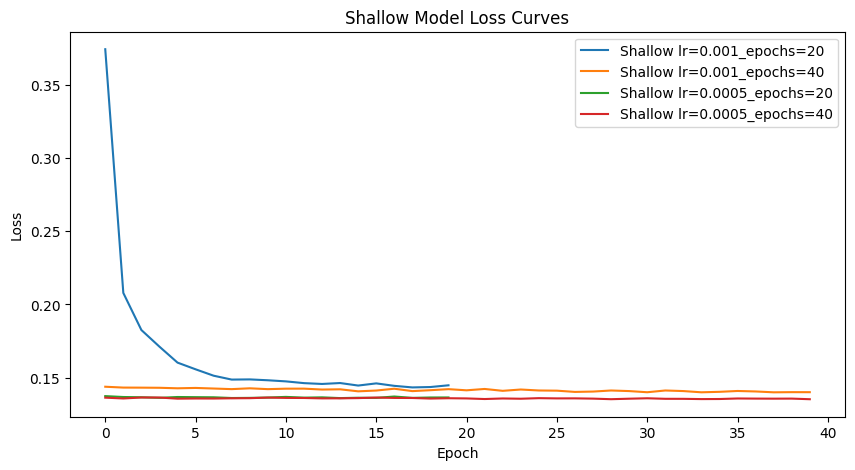

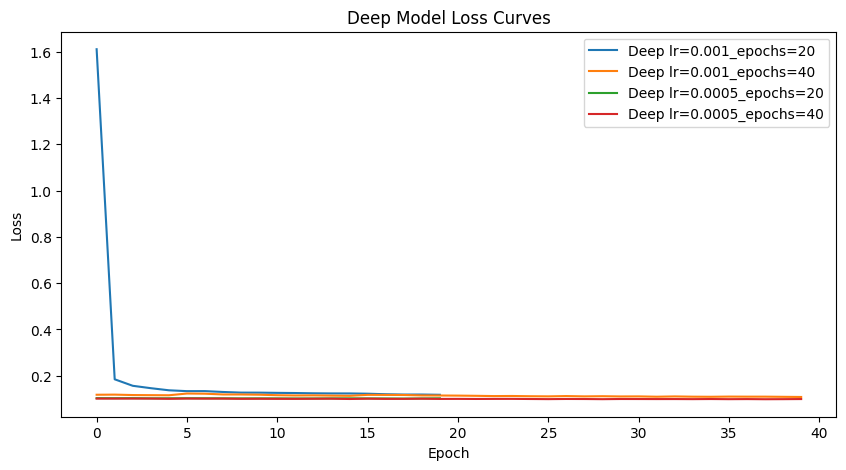

In [52]:
# Plotting Shallow Model Loss Curves
plt.figure(figsize=(10, 5))
for key, loss_history in shallow_loss_curves.items():
    plt.plot(loss_history, label=f"Shallow {key}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Shallow Model Loss Curves")
plt.legend()
plt.show()

# Plotting Deep Model Loss Curves
plt.figure(figsize=(10, 5))
for key, loss_history in deep_loss_curves.items():
    plt.plot(loss_history, label=f"Deep {key}")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Deep Model Loss Curves")
plt.legend()
plt.show()

## Readme.md
In your ReadMe file, explain why you chose the classifiers/regressors and provide comments on the impact of the tunable parameters on the accuracy. Also, compare the selected models.

For PySpark, the two models selected were Randok Forest Regressor and MLP. These two models were selected 

## PySpark
For PySpark, the two selected regressors were Random Forests Regressor and Linear Regressor. The Random forest regressor was selected because it handles string-index categorical data well, where categories are represented numerically but the magnitude of the numbers do not imply real-life meanings. The Linear Regressor was chosen for its efficiency and straightforward implementation in handling linearly related data, which makes it a good baseline model in comparison with more complex methods.

Tunable parameters for random forests:
- Number of Trees (numTrees): Increasing the number of trees generally improved model stability and accuracy, though the improvement in accuracy brought by increasing number of treess becomes smaller at high values of numTrees.
- Max Depth (maxDepth): Controls the depth of each tree, balancing model complexity and overfitting. Shallow trees had faster training times but lower accuracy, while deeper trees had improved accuracy with the risk of overfitting.

Tunable Parameters for Linear Regression:
- Regularization Parameter (regParam): This parameter controls the degree of regularization applied to the Linear Regressor, which helps reduce overfitting by penalizing large weights. Lower values of regParam allow the model to fit the data more closely, which can be beneficial in cases with simpler data but may lead to overfitting on more complex datasets. Higher values provide stronger regularization, which can improve generalization but may cause underfitting.
- maxIter: This parameter determines the maximum number of iterations for the optimization algorithm. Increasing maxIter can allow the model more time to converge to the optimal solution, which may improve accuracy, especially if the dataset is large or complex. However, very high values for maxIter may lead to longer training times without significant accuracy gains.

The Random Forest and Linear Regression models were chosen for their complementary strengths: Random Forests provide better handling of complex feature interactions and categorical data, while Linear Regression serves as an effective, interpretable baseline. By comparing both models, it’s possible to assess the linear versus non-linear relationships within the data and gain insights into model performance on this dataset.

## PyTorch
For PyTorch, two models were selected, a deep NN and a shallow NN. For the shallow NN, it was constructed with only one hidden layer of 64 neurons. The deep NN, has a more complex structure, with 4 hidden layers containing 128, 64, 32, and 16 neurons respectively. 

Tunable parameters for neural networks: 

- Learning Rate: Controls how big are the steps that the model takes to update weights. Higher learning rates can speed up convergence and help avoid stucking in local minima, but may risk overshooting and unstable training. Lower learning rates offer stability but may increase the time needed for convergence and may get model stuck in local minima. During tuning, we observed that lower learning rates (e.g., 0.0005) led to better performance in both deep and shallow NN, and we didn't see a visually obvious difference between them.

- Epochs: The number of complete passes through the training dataset. Higher epoch counts typically improve accuracy by allowing the model more opportunities to learn more, though excessive epochs can lead to overfitting. Increasing epochs improved the accuracy of both shallow and deep NN model up to a certain threshold, after which led to overfitting. The DeepNN, in particular, we saw it significantly benefited from higher epochs (we compared 10 vs 40), as it has large amount of parameters and need more training iterations to learn.

If needed, we could also adjust the number of hidden layers and number of neurons in each hidden layer to increase model accuracy. To compare the shallow and deep NN, with more hidden layers, the deep NN therotically should achieve lower losses and higher accuracy on test data, because it's able to capture more complex features than shallow NN. But this also requires more time to train the data compared to shallow NN. While deep NN has the capability to perform better on training and test data, its structure also makes it prone to overfitting problems.

## 